In [4]:
import numpy as np
import tensorflow as tf

In [2]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [5]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [6]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

In [7]:
# the number of observations in the dataset
n_observations = int(1e4)

# boolean feature, encoded as False or True
feature0 = np.random.choice([False, True], n_observations)

# integer feature, random from 0 .. 4
feature1 = np.random.randint(0, 5, n_observations)

# string feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

In [9]:
feature2

array([b'cat', b'dog', b'cat', ..., b'chicken', b'cat', b'cat'],
      dtype='|S7')

In [58]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.Example message ready to be written to a file.
  """
  
  # Create a dictionary mapping the feature name to the tf.Example-compatible
  # data type.
  
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }
  
  # Create a Features message using tf.train.Example.
  
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [13]:
serialized_example = serialize_example(False, 4, b'goat', 0.9876)

In [14]:
example_proto = tf.train.Example.FromString(serialized_example)

In [15]:
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

In [16]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))

In [26]:
for element in features_dataset:
    print(element)
    break

(<tf.Tensor: id=115, shape=(), dtype=bool, numpy=False>, <tf.Tensor: id=116, shape=(), dtype=int64, numpy=0>, <tf.Tensor: id=117, shape=(), dtype=string, numpy=b'cat'>, <tf.Tensor: id=118, shape=(), dtype=float64, numpy=-1.7982914546647135>)


In [41]:
features_dataset.map(serialize_example)

AttributeError: 'Tensor' object has no attribute 'numpy'

In [29]:
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [42]:
def tf_seralize_example(f0, f1, f2, f3):
    tf_string = tf.py_function(
                                serialize_example,
                                (f0, f1, f2, f3),
                                tf.string)
    return tf.reshape(tf_string, ())

In [43]:
sereliazed_ds = features_dataset.map(tf_seralize_example)

In [44]:
tf.data.experimental.TFRecordWriter("test.tfrecord").write(sereliazed_ds)

W0624 06:49:01.697157 140674179516160 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.bool
W0624 06:49:01.698336 140674179516160 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


In [45]:
!ls -l

total 1036
-rw-r--r-- 1 root root    9215 Jun 24 02:27 data-exploration.ipynb
-rw-r--r-- 1 root root 1004055 Jun 24 06:49 test.tfrecord
-rw-r--r-- 1 root root   38329 Jun 24 06:43 tfrecords.ipynb


In [46]:
raw_dataset = tf.data.TFRecordDataset(["test.tfrecord"])

In [47]:
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [48]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: id=90207, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04j.\xe6\xbf'>
<tf.Tensor: id=90209, shape=(), dtype=string, numpy=b'\nQ\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xd2\\\x0c?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>
<tf.Tensor: id=90211, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x1e\xc37\xbf'>
<tf.Tensor: id=90213, shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x00\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xa7\x81\xd4\xbe'>
<t

In [52]:
# Create a description of the features.  
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [53]:
parsed_dataset = raw_dataset.map(_parse_function)

In [54]:
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [55]:
for parse_record in parsed_dataset.take(10):
    print(repr(parse_record))

{'feature0': <tf.Tensor: id=90260, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=90261, shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: id=90262, shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: id=90263, shape=(), dtype=float32, numpy=-1.7982914>}
{'feature0': <tf.Tensor: id=90268, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=90269, shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: id=90270, shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: id=90271, shape=(), dtype=float32, numpy=0.5482913>}
{'feature0': <tf.Tensor: id=90276, shape=(), dtype=int64, numpy=1>, 'feature1': <tf.Tensor: id=90277, shape=(), dtype=int64, numpy=0>, 'feature2': <tf.Tensor: id=90278, shape=(), dtype=string, numpy=b'cat'>, 'feature3': <tf.Tensor: id=90279, shape=(), dtype=float32, numpy=-0.717821>}
{'feature0': <tf.Tensor: id=90284, shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: id=90285, shape=(), dtype=int64, numpy=0>, 'feature2

In [59]:
with tf.io.TFRecordWriter("python_saver.tfrecords") as writer:
    for i in range(n_observations):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)

In [60]:
!ls -la

total 2028
drwxr-xr-x 3 1000 1000    4096 Jun 24 07:33 .
drwxr-xr-x 1 root root    4096 Jun 24 01:38 ..
drwxr-xr-x 2 root root    4096 Jun 24 04:38 .ipynb_checkpoints
-rw-r--r-- 1 root root    9215 Jun 24 02:27 data-exploration.ipynb
-rw-r--r-- 1 root root 1004055 Jun 24 07:34 python_saver.tfrecords
-rw-r--r-- 1 root root 1004055 Jun 24 06:49 test.tfrecord
-rw-r--r-- 1 root root   33422 Jun 24 07:33 tfrecords.ipynb


In [81]:
raw_dataset = tf.data.TFRecordDataset("/data/kmnist_dev.tfrecord")

In [82]:
feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [83]:
parsed_dataset = raw_dataset.map(_parse_function)

In [84]:
img_dataset = parsed_dataset.map(lambda x: tf.io.parse_tensor(x["image_raw"], tf.uint8))

In [85]:
img_dataset

<MapDataset shapes: <unknown>, types: tf.uint8>

In [78]:
import matplotlib.pyplot as plt

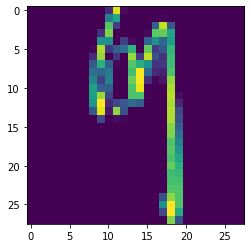

In [86]:
for x in img_dataset.take(1):
    plt.imshow(x)